# Dummy example for gym environment with FMU and SKRL

In [1]:
import os, sys
import time
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt

from fmpy import read_model_description, extract

from fmugym import FMUGym, FMUGymConfig, VarSpace, State2Out, TargetValue

import gymnasium as gym

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# import the skrl components to build the RL system
from skrl.agents.torch.sac import SAC_DEFAULT_CONFIG
from skrl.agents.torch.sac import SAC_RNN as SAC
from skrl.envs.wrappers.torch import wrap_env
from skrl.memories.torch import RandomMemory
from skrl.models.torch import DeterministicMixin, GaussianMixin, Model
from skrl.trainers.torch import SequentialTrainer
from skrl.utils import set_seed
from skrl.envs.wrappers.torch import wrap_env

In [3]:
set_seed(0)

[skrl:INFO] Seed: 0


0

## Define model of NN for SAC algorithm

In [4]:
# define models (stochastic and deterministic models) using mixins
class Actor(GaussianMixin, Model):
    def __init__(self, observation_space, action_space, device, clip_actions=False,
                 clip_log_std=True, min_log_std=-20, max_log_std=2, reduction="sum",
                 num_envs=1, num_layers=1, hidden_size=256, sequence_length=20):
        Model.__init__(self, observation_space, action_space, device)
        GaussianMixin.__init__(self, clip_actions, clip_log_std, min_log_std, max_log_std, reduction)

        self.num_envs = num_envs
        self.num_layers = num_layers
        self.hidden_size = hidden_size  # Hout
        self.sequence_length = sequence_length

        self.rnn = nn.RNN(input_size=self.num_observations,
                          hidden_size=self.hidden_size,
                          num_layers=self.num_layers,
                          batch_first=True)  # batch_first -> (batch, sequence, features)

        self.linear_layer_1 = nn.Linear(self.hidden_size, 256)
        self.action_layer = nn.Linear(256, self.num_actions)

        self.log_std_parameter = nn.Parameter(torch.zeros(self.num_actions))

    def get_specification(self):
        # batch size (N) is the number of envs
        return {"rnn": {"sequence_length": self.sequence_length,
                        "sizes": [(self.num_layers, self.num_envs, self.hidden_size)]}}  # hidden states (D ∗ num_layers, N, Hout)

    def compute(self, inputs, role):
        states = inputs["states"]
        terminated = inputs.get("terminated", None)
        hidden_states = inputs["rnn"][0]

        # training
        if self.training:
            rnn_input = states.view(-1, self.sequence_length, states.shape[-1])  # (N, L, Hin): N=batch_size, L=sequence_length
            hidden_states = hidden_states.view(self.num_layers, -1, self.sequence_length, hidden_states.shape[-1])  # (D * num_layers, N, L, Hout)
            # get the hidden states corresponding to the initial sequence
            hidden_states = hidden_states[:,:,0,:].contiguous()  # (D * num_layers, N, Hout)

            # reset the RNN state in the middle of a sequence
            if terminated is not None and torch.any(terminated):
                rnn_outputs = []
                terminated = terminated.view(-1, self.sequence_length)
                indexes = [0] + (terminated[:,:-1].any(dim=0).nonzero(as_tuple=True)[0] + 1).tolist() + [self.sequence_length]

                for i in range(len(indexes) - 1):
                    i0, i1 = indexes[i], indexes[i + 1]
                    rnn_output, hidden_states = self.rnn(rnn_input[:,i0:i1,:], hidden_states)
                    hidden_states[:, (terminated[:,i1-1]), :] = 0
                    rnn_outputs.append(rnn_output)

                rnn_output = torch.cat(rnn_outputs, dim=1)
            # no need to reset the RNN state in the sequence
            else:
                rnn_output, hidden_states = self.rnn(rnn_input, hidden_states)
        # rollout
        else:
            rnn_input = states.view(-1, 1, states.shape[-1])  # (N, L, Hin): N=num_envs, L=1
            rnn_output, hidden_states = self.rnn(rnn_input, hidden_states)

        # flatten the RNN output
        rnn_output = torch.flatten(rnn_output, start_dim=0, end_dim=1)  # (N, L, D ∗ Hout) -> (N * L, D ∗ Hout)

        x = F.relu(self.linear_layer_1(rnn_output))

        # Pendulum-v1 action_space is -2 to 2
        return 2 * torch.tanh(self.action_layer(x)), self.log_std_parameter, {"rnn": [hidden_states]}

class Critic(DeterministicMixin, Model):
    def __init__(self, observation_space, action_space, device, clip_actions=False,
                 num_envs=1, num_layers=1, hidden_size=256, sequence_length=20):
        Model.__init__(self, observation_space, action_space, device)
        DeterministicMixin.__init__(self, clip_actions)

        self.num_envs = num_envs
        self.num_layers = num_layers
        self.hidden_size = hidden_size  # Hout
        self.sequence_length = sequence_length

        self.rnn = nn.RNN(input_size=self.num_observations,
                          hidden_size=self.hidden_size,
                          num_layers=self.num_layers,
                          batch_first=True)  # batch_first -> (batch, sequence, features)

        self.linear_layer_1 = nn.Linear(self.hidden_size + self.num_actions, 256)
        self.linear_layer_3 = nn.Linear(256, 1)

    def get_specification(self):
        # batch size (N) is the number of envs
        return {"rnn": {"sequence_length": self.sequence_length,
                        "sizes": [(self.num_layers, self.num_envs, self.hidden_size)]}}  # hidden states (D ∗ num_layers, N, Hout)

    def compute(self, inputs, role):
        states = inputs["states"]
        terminated = inputs.get("terminated", None)
        hidden_states = inputs["rnn"][0]

        # critic is only used during training
        rnn_input = states.view(-1, self.sequence_length, states.shape[-1])  # (N, L, Hin): N=batch_size, L=sequence_length

        hidden_states = hidden_states.view(self.num_layers, -1, self.sequence_length, hidden_states.shape[-1])  # (D * num_layers, N, L, Hout)
        # get the hidden states corresponding to the initial sequence
        sequence_index = 1 if role in ["target_critic_1", "target_critic_2"] else 0  # target networks act on the next state of the environment
        hidden_states = hidden_states[:,:,sequence_index,:].contiguous()  # (D * num_layers, N, Hout)

        # reset the RNN state in the middle of a sequence
        if terminated is not None and torch.any(terminated):
            rnn_outputs = []
            terminated = terminated.view(-1, self.sequence_length)
            indexes = [0] + (terminated[:,:-1].any(dim=0).nonzero(as_tuple=True)[0] + 1).tolist() + [self.sequence_length]

            for i in range(len(indexes) - 1):
                i0, i1 = indexes[i], indexes[i + 1]
                rnn_output, hidden_states = self.rnn(rnn_input[:,i0:i1,:], hidden_states)
                hidden_states[:, (terminated[:,i1-1]), :] = 0
                rnn_outputs.append(rnn_output)

            rnn_output = torch.cat(rnn_outputs, dim=1)
        # no need to reset the RNN state in the sequence
        else:
            rnn_output, hidden_states = self.rnn(rnn_input, hidden_states)

        # flatten the RNN output
        rnn_output = torch.flatten(rnn_output, start_dim=0, end_dim=1)  # (N, L, D ∗ Hout) -> (N * L, D ∗ Hout)

        x = F.relu(self.linear_layer_1(torch.cat([rnn_output, inputs["taken_actions"]], dim=1)))

        return self.linear_layer_3(x), {"rnn": [hidden_states]}

### Parameters of the simulation

In [5]:
class FMUEnv(FMUGym):
    def __init__(self, config):
        super().__init__(config)
        self.setpoint = None

    def _get_info(self):
        return {'info_time':time.time(), "setpoint":self.setpoint}

    # possibility to do processing of FMU outputs to observations of the environment, 
    # here the observation is composed of first two entries of FMU outputs and the following two as setpoints to these outputs
    def _get_obs(self):
        
        self._get_fmu_output()

        obs = np.array(list(self.observation.values())).flatten()
        
        noisy_observation = obs + self._get_output_noise()
        
        self.setpoint = self.setpoint_trajectory(self.y_start, self.y_stop, self.time)
        full_obs = np.append(noisy_observation, self.setpoint)
        
        return full_obs
    
    def _get_input_noise(self):
        input_noise = []
        for inp_name in self.input_dict:
            input_noise.append(self.input_noise[inp_name].sample()[0])
        return np.array(input_noise)

    def _get_output_noise(self):
        output_noise = []
        for out_name in self.output_dict:
                output_noise.append(self.output_noise[out_name].sample()[0])
        return np.array(output_noise)

    def _get_terminated(self):
        if self.time > self.stop_time:
            self.reset()
            return True, False

        for termination in self.terminations:
            min = self.terminations[termination].low[0]
            max = self.terminations[termination].high[0]
            if self.observation[termination] < min or self.observation[termination] > max:
                self.reset()
                return False, True

        return False, False

    def _create_action_space(self, inputs):
        lows = []
        highs = []
        for inp in inputs:
            lows.append(inputs[inp].low[0])
            highs.append(inputs[inp].high[0])
        action_space = gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        return action_space
    
    def _create_observation_space(self, outputs):
        lows = []
        highs = []
        for out in outputs:
            lows.append(outputs[out].low[0])
            highs.append(outputs[out].high[0])
        observation_space = gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        return observation_space

    def _noisy_init(self):
        # add noise to setpoint goals
        for ye in self.y_stop:
            self.y_stop[ye] = self.y_stop_range[ye].sample()[0]
        
        # add noise to initial system state
        init_states = {}
        for var in self.random_vars_refs:
            var_ref = self.random_vars_refs[var][0]
            uniform_value = self.random_vars_refs[var][1].sample()[0]
            init_states[var_ref] = uniform_value

            # domain randomization with noisy initial y_start
            if var in self.rand_starts.keys():
                input_string = self.rand_starts[var]
                self.y_start[input_string] = float(uniform_value)
        
        return init_states

    def _process_action(self, action):
        processed_action = action + self._get_input_noise()
        return processed_action

    def setpoint_trajectory(self, y_start, y_stop, time):
        y = []
        for y0, ye in zip(y_start.values(), y_stop.values()):
            y.append((ye - y0)/(self.stop_time-self.start_time)*(time-self.start_time) + y0)
        return np.array(y)

    def _process_reward(self, obs, acts, info):
        reward = self.compute_reward(obs, info)
        return reward
    
    def compute_reward(self, obs, info):
        # Deceptive reward: it is positive (0) only when the goal is achieved
        # Here we are using a vectorized version
        control_error = obs[:2] - obs[2:]
        reward = - np.sum(control_error**2)
        
        return reward

In [6]:
inputs = VarSpace("inputs")
inputs.add_var_box("input1", -2.0, 2.0)
inputs.add_var_box("input2", -2.0, 2.0)

input_noise = VarSpace("input_noise")
input_noise.add_var_box("input1", 0.0, 0.0)
input_noise.add_var_box("input2", 0.0, 0.0)

outputs = VarSpace("outputs")
outputs.add_var_box("output1", -1e6, 1e6)
outputs.add_var_box("output2", -1e6, 1e6)
outputs.add_var_box("setpoint1", -1e6, 1e6)
outputs.add_var_box("setpoint2", -1e6, 1e6)

output_noise = VarSpace("output_noise")
output_noise.add_var_box("output1", 0.0, 0.0)
output_noise.add_var_box("output2", 0.0, 0.0)

# dynamics and domain randomization
random_vars = VarSpace("random_vars")
random_vars.add_var_box("firstOrder.k", 4, 6)
random_vars.add_var_box("firstOrder1.k", 4, 6)
random_vars.add_var_box("firstOrder.y_start", -0.5, 0.5)
random_vars.add_var_box("firstOrder1.y_start", -0.5, 0.5)

# map state variables to corresponding outputs of Modelica Model
set_point_map = State2Out("set_point_map")
set_point_map.add_map("firstOrder.y_start", "output1")
set_point_map.add_map("firstOrder1.y_start", "output2")

set_point_nominal_start = TargetValue("set_point_nominal_start")
set_point_nominal_start.add_target("output1", 0.0)
set_point_nominal_start.add_target("output2", 0.0)

set_point_stop = VarSpace("set_point_stop")
set_point_stop.add_var_box("output1", 1.0, 2.5)
set_point_stop.add_var_box("output2", 1.2, 3.0)

terminations = VarSpace("terminations")

config = FMUGymConfig(fmu_path=os.path.abspath('FMUs/dummy_for_FMU_cosim.fmu'),
                      start_time=0.0,
                      stop_time=10.0,
                      sim_step_size=0.01,
                      action_step_size=0.01,
                      inputs=inputs,
                      input_noise=input_noise,
                      outputs=outputs,
                      output_noise=output_noise,
                      random_vars=random_vars,
                      set_point_map=set_point_map,
                      set_point_nominal_start=set_point_nominal_start,
                      set_point_stop=set_point_stop,
                      terminations=terminations
                     )                        

In [7]:
model_description = read_model_description(config.fmu_path)
print(model_description)

ModelDescription(fmiVersion='2.0', modelName='dummy_for_FMU', coSimulation=CoSimulation(modelIdentifier='testexport_fmu'), modelExchange=None, scheduledExecution=None)


### Creation of gym environment

In [8]:
dummyEnv = FMUEnv(config)
env = wrap_env(dummyEnv, wrapper="gymnasium")

[skrl:INFO] Environment wrapper: gymnasium


LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF


In [9]:
device = env.device

In [10]:
# instantiate a memory as experience replay
memory = RandomMemory(memory_size=2000, num_envs=env.num_envs, device=device, replacement=True)

### Creation of SKRL agent

In [11]:
# instantiate the agent's models (function approximators).
# SAC requires 5 models, visit its documentation for more details
# https://skrl.readthedocs.io/en/latest/api/agents/sac.html#models
models = {}
models["policy"] = Actor(env.observation_space, env.action_space, device, clip_actions=True, num_envs=env.num_envs)
models["critic_1"] = Critic(env.observation_space, env.action_space, device, num_envs=env.num_envs)
models["critic_2"] = Critic(env.observation_space, env.action_space, device, num_envs=env.num_envs)
models["target_critic_1"] = Critic(env.observation_space, env.action_space, device, num_envs=env.num_envs)
models["target_critic_2"] = Critic(env.observation_space, env.action_space, device, num_envs=env.num_envs)

# initialize models' parameters (weights and biases)
for model in models.values():
    model.init_parameters(method_name="normal_", mean=0.0, std=0.1)

In [12]:
# configure and instantiate the agent (visit its documentation to see all the options)
# https://skrl.readthedocs.io/en/latest/api/agents/sac.html#configuration-and-hyperparameters
cfg = SAC_DEFAULT_CONFIG.copy()
cfg["discount_factor"] = 0.99
cfg["batch_size"] = 64
cfg["random_timesteps"] = 0
cfg["learning_starts"] = 100
cfg["learn_entropy"] = True
# logging to TensorBoard and write checkpoints (in timesteps)
cfg["experiment"]["write_interval"] = 500
cfg["experiment"]["checkpoint_interval"] = 2000
cfg["experiment"]["directory"] = "runs/torch/FMUGym"

In [13]:
agent = SAC(models=models,
            memory=memory,
            cfg=cfg,
            observation_space=env.observation_space,
            action_space=env.action_space,
            device=device)


# configure and instantiate the RL trainer
cfg_trainer = {"timesteps": int(1e5), "headless": True}
trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=[agent])

### Learning of SKRL agent

In [14]:
import time
timer_start_time = time.time()
trainer.train()
print("learn duration: ", time.time() - timer_start_time)

LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF
  1%|▎                                  | 1000/100000 [01:00<2:20:16, 11

In [19]:
agent.save("trained_agents/skrl_sac.pth")

### ... or loading model

In [33]:
agent.load("trained_agents/skrl_sac.pth")

### Inference

In [16]:
observation, info = env.reset()
obs_array = []
act_array = []
obs_array.append(observation.numpy()[0][0:4])
rew_sum = 0

num_steps = int((config.stop_time - config.start_time) / config.sim_step_size)
for num_step in range(num_steps):
    action, _, _ = agent.act(states=observation, timestep=num_step, timesteps=num_steps)
    action = action.clone().detach().requires_grad_(False) # transform it to be used in env
    observation, reward, terminated, truncated, info = env.step(action)

    rew_sum += reward
    if terminated or truncated:
        observation, info = env.reset()
    obs_array.append(observation.numpy()[0][:4])
    act_array.append(action.numpy())

obs_array = np.array(obs_array).flatten()
obs_array = obs_array.reshape(-1, 4)  
act_array = np.array(act_array).flatten()
act_array = act_array.reshape(-1, 2) 

LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF


In [17]:
y1_setpoints = obs_array[:, 2]
y2_setpoints = obs_array[:, 3]

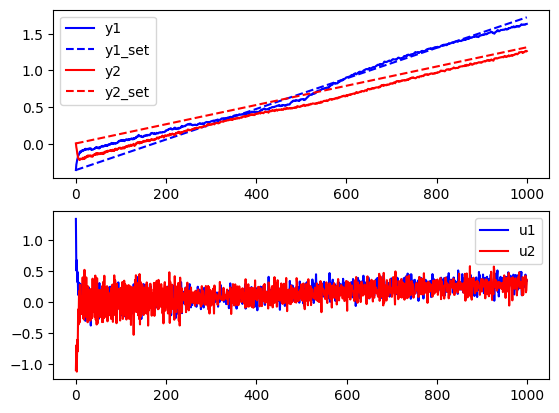

In [18]:
plt.subplot(2, 1, 1)
plt.plot(obs_array[:, 0], label='y1', color="b")
plt.plot(y1_setpoints, label='y1_set', color="b", linestyle='--')
plt.plot(obs_array[:, 1], label='y2', color="r")
plt.plot(y2_setpoints, label='y2_set', color="r", linestyle='--')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(act_array[:, 0], label='u1', color="b")
plt.plot(act_array[:, 1], label='u2', color="r")
plt.legend()

plt.show()

In [14]:
dummyEnv.close()